In [1]:
import tensorflow as tf

tf.__version__

'2.3.0'

# Load Data

In [2]:
import os
import datetime
DATA_DIR = r'E:\Guanru\Unet\refugedata_seg'

x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/mask')

# Tensorboard

In [3]:
import tensorflow as tf
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train process

In [6]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 16228), started 2 days, 13:41:53 ago. (Use '!kill 16228' to kill it.)

In [ ]:
import U3Net as u3
import data as da
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import importlib

importlib.reload(da)
importlib.reload(u3)


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

#IOU = tf.keras.metrics.MeanIoU(num_classes, name=None, dtype=None)

myGene = da.trainGenerator(2,os.path.join(DATA_DIR, 'train'),
                           'image','mask',
                           data_gen_args,save_to_dir = None,
                           num_class=3,
                           target_size=(512,512),
                           flag_multi_class=True,
                          image_color_mode='rgb',
                          mask_color_mode = "rgb")

model = u3.M3U_Netpp(512,512,channel=3,num_class=3,deep_supervision=True,dilate_mode = True,nb_conv = 1)
model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy',
            tf.keras.metrics.MeanIoU(3, name=None, dtype=None)])

train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_checkpoint = ModelCheckpoint('model/{}-best.h5'.format(train_time), monitor='loss',verbose=1, save_best_only=True)

model.summary()

print("training............")
model.fit(myGene, steps_per_epoch=100, epochs=50, callbacks=[model_checkpoint,tensorboard_callback ])

model.save('model/{}-last.h5'.format(train_time))

/device:GPU:0
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 512, 512, 32) 896         main_input[0][0]                 
__________________________________________________________________________________________________
drop00_1 (Dropout)              (None, 512, 512, 32) 0           conv00_1[0][0]                   
__________________________________________________________________________________________________
bn00 (BatchNormalization)       (None, 512, 512, 32) 128         drop00_1[0][0]                   
________________________________________________________________________

Epoch 1/50
  1/100 [..............................] - ETA: 0s - loss: 0.8897 - accuracy: 0.0061 - mean_io_u_6: 0.4996

# Test Proccess(bug)

In [14]:
DATA_DIR

'E:\\Guanru\\Unet\\refugedata_seg'

In [42]:

import data as da

import importlib

importlib.reload(da)

print("testing...........")
testGene = da.testGenerator(os.path.join(DATA_DIR, 'test'),target_size=(512,512),flag_multi_class = True)
# model = unet("unet_membrane.hdf5")
# model = unet("unet_liverCT_fulliamge.hdf5")
model = tf.keras.models.load_model("model/20210525-183238-last.h5")
# model.load_weights("unet_membrane.hdf5")

results = model.predict_generator(testGene, 10, verbose=1)

threshold = 0.7
for test_image in results[:,:,:,2]:
    print(test_image)
    test_image[test_image > 0] = 0
    print(test_image)
for test_image in results[:,:,:,1]:
    print(test_image)
    test_image[test_image >= threshold] = 1
    test_image[test_image < threshold] = 0
    print(test_image)
for test_image in results[:,:,:,0]:
    print(test_image)
    test_image[test_image >= threshold] = 2
    test_image[test_image < threshold] = 0
    print(test_image)
# for i in results[:,:,:,1]:
#     results[results >= threshold] = 1
#     results[results < threshold] = 0
# for i in results[:,:,:,2]:
#     results[results >= threshold] = 2
#     results[results < threshold] = 0
da.saveResult(r"E:\Guanru\Unet\GlaucomaDetec_Unet\pred", results)

testing...........
1/1 [==============================] - 0s 58ms/step


E:\Guanru\Unet\GlaucomaDetec_Unet\data.py:143: UserWarning: E:\Guanru\Unet\GlaucomaDetec_Unet\pred\0_predict.png is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[[0.5739125  0.5401516  0.556621   ... 0.57955617 0.61298126 0.5527356 ]
 [0.6235015  0.5345421  0.60057086 ... 0.54045165 0.583801   0.5058757 ]
 [0.66363037 0.62101    0.638173   ... 0.5842862  0.6259268  0.5238916 ]
 ...
 [0.61017233 0.52000433 0.5523822  ... 0.5565914  0.5816447  0.5433117 ]
 [0.63284695 0.5873258  0.60846055 ... 0.6466099  0.6285622  0.576709  ]
 [0.6720245  0.6400717  0.63048255 ... 0.6737699  0.6070825  0.5707327 ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.3174963  0.41470614 0.37264258 ... 0.41112036 0.34524214 0.3872118 ]
 [0.34498954 0.41146597 0.35697588 ... 0.43295157 0.3689491  0.40574566]
 [0.28056782 0.36780584 0.3179562  ... 0.39565617 0.36575484 0.39590162]
 ...
 [0.2918934  0.35357255 0.36323547 ... 0.38777024 0.35656315 0.36453754]
 [0.29535228 0.3446485  0.3545469  ... 0.33125815 0.3361814  0.34002328]
 [0.2432026  0.2701263  0.3256

In [18]:
print(results.shape)

(20, 512, 512, 3)


In [ ]:
import model as md
import data as da

import importlib
importlib.reload(md)
importlib.reload(da)

In [62]:
results[0]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [22]:
from PIL import Image

Image.open(os.path.join("E:\Server_mantain\GlaucomaDetec_Unet\pred","test27.jpg")).save("sample1.bmp")

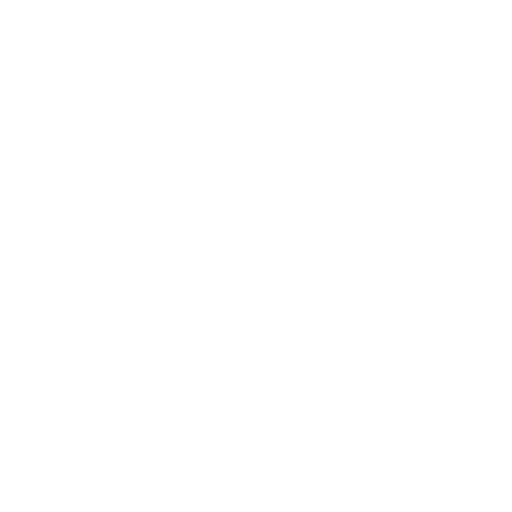

In [23]:
load_img(os.path.join("E:\Server_mantain\GlaucomaDetec_Unet\GlaucomaDetec_Unet",'sample1.bmp'))

In [12]:
import cv2
%matplotlib inline

#image = cv2.imread("test.png")
cv2.imshow("test", results[0])
#  add below code
cv2.waitKey(0)
cv2.destroyAllWindows()

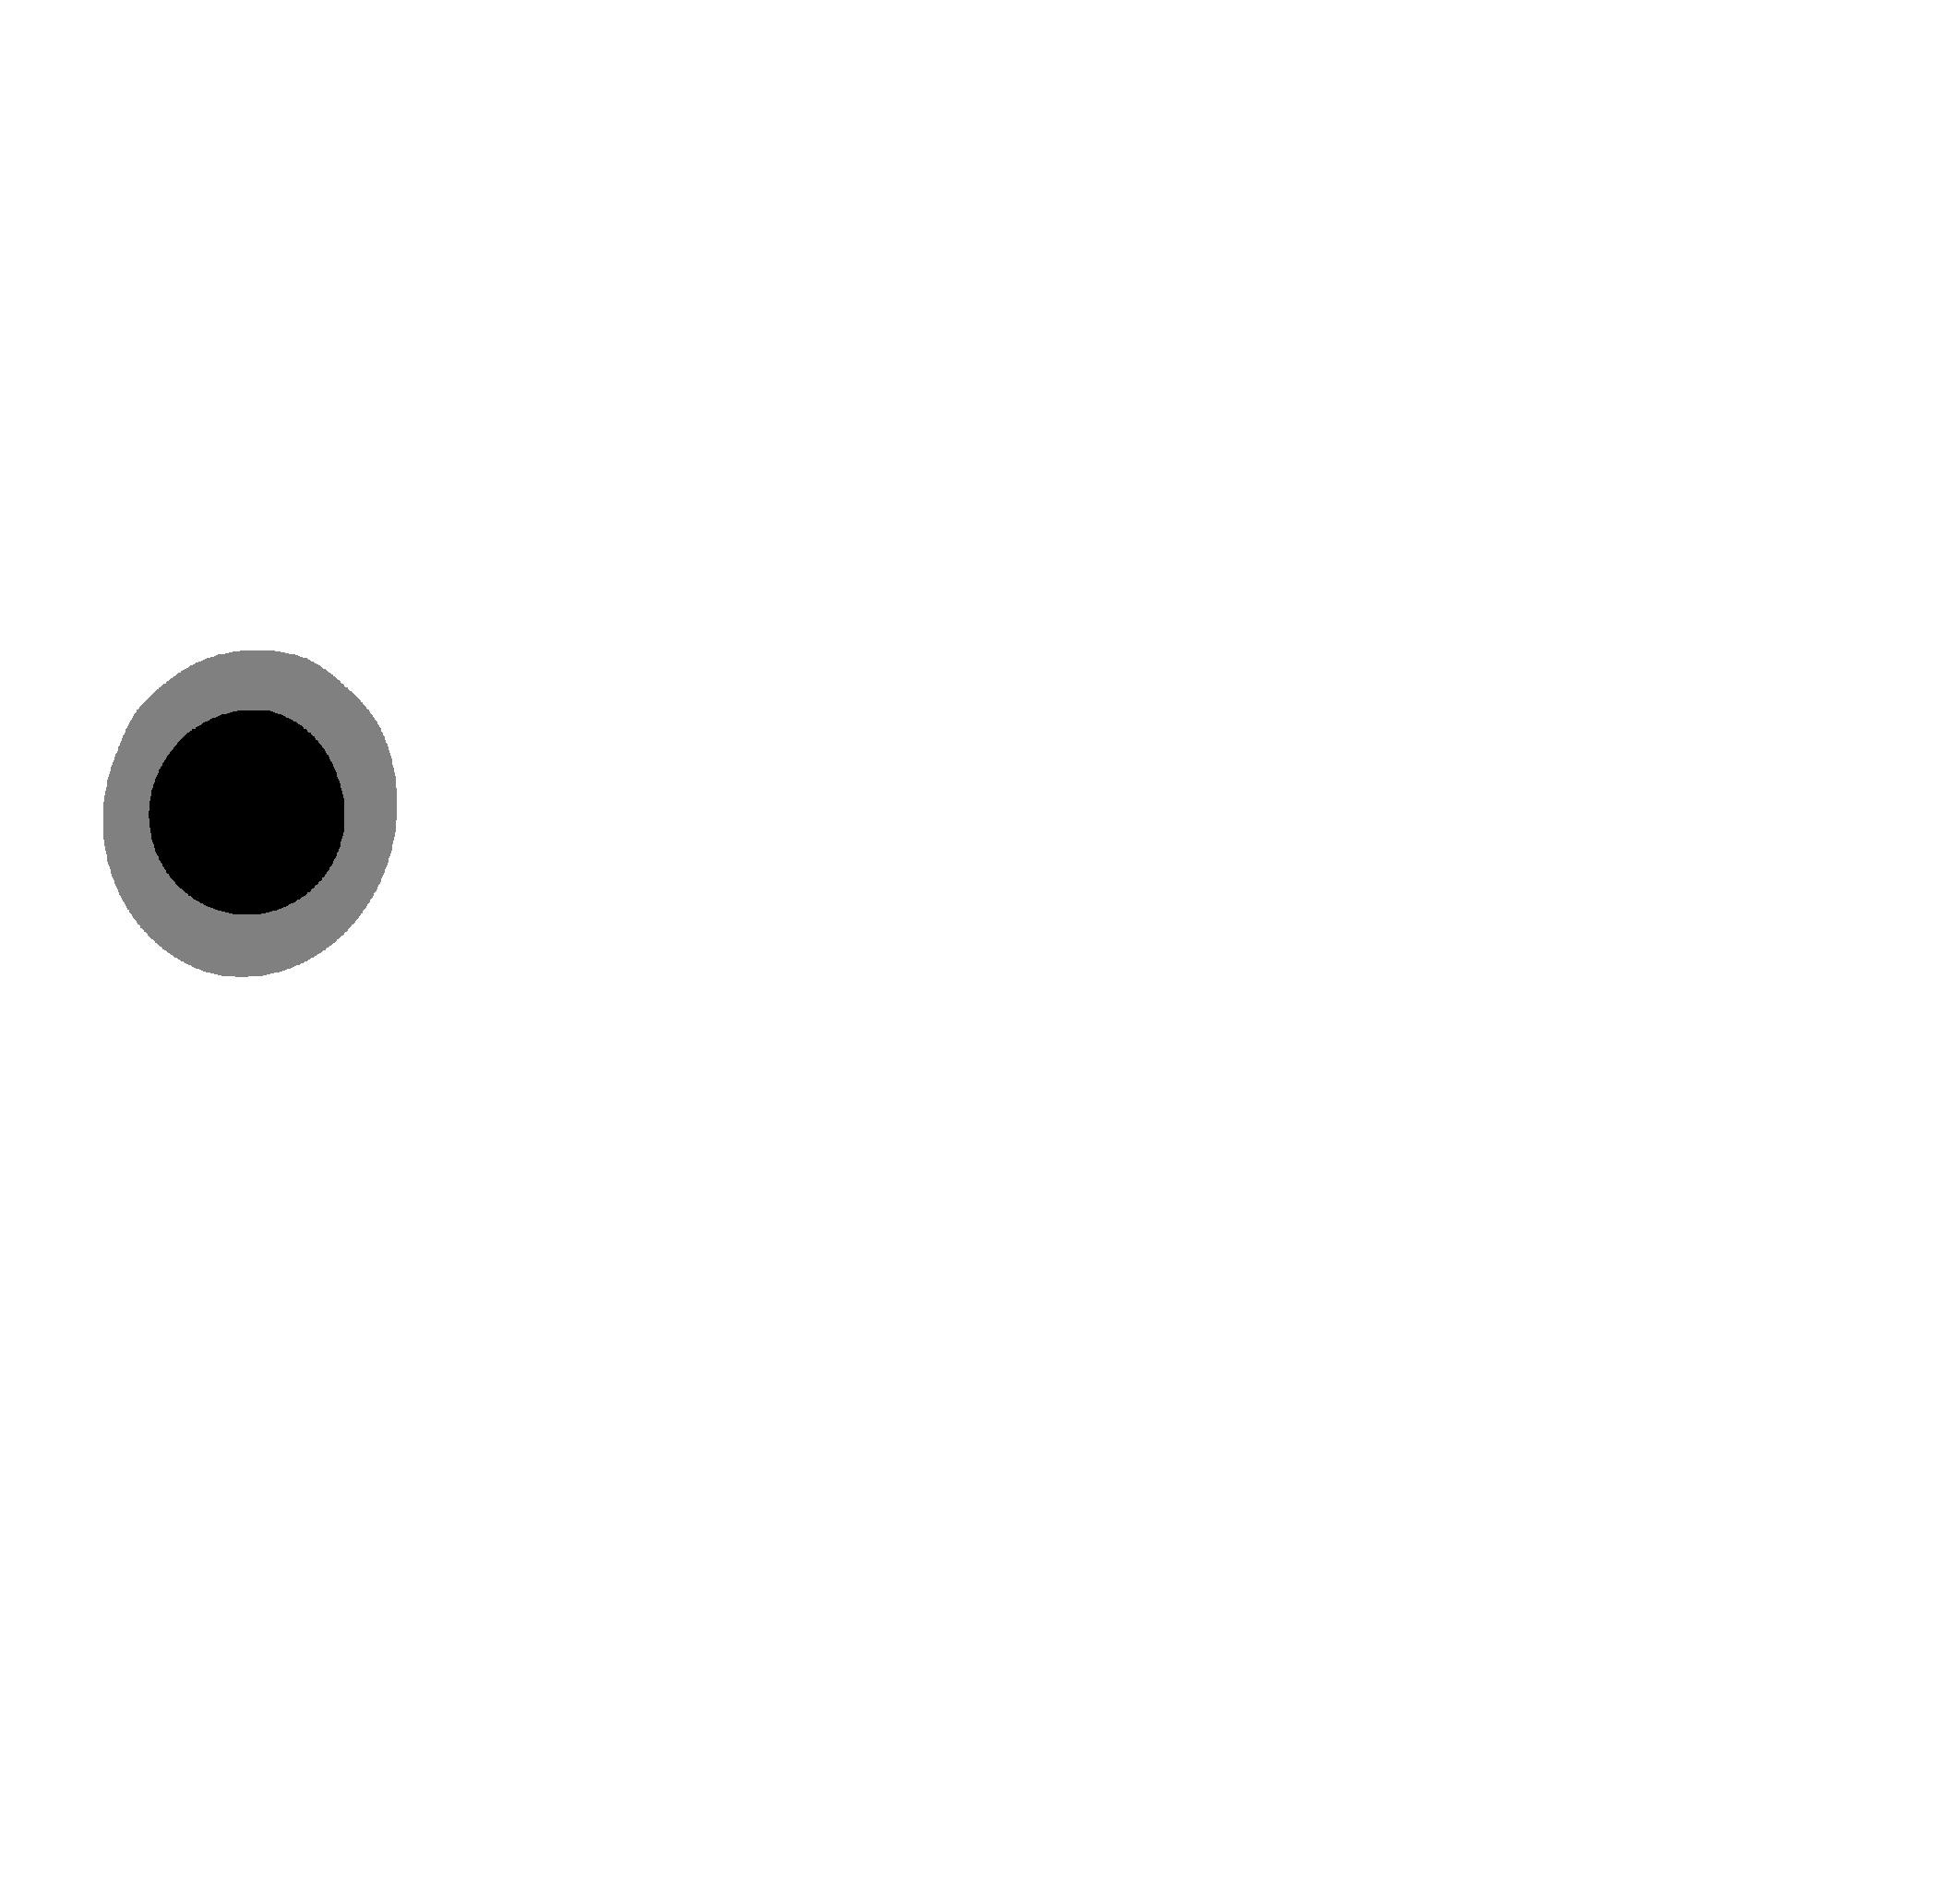

In [20]:
load_img(os.path.join(DATA_DIR, 'train','mask','g0001.bmp'))

In [19]:
img_to_array(load_img(os.path.join(DATA_DIR, 'train','mask','g0001.bmp'))).shape

(2056, 2124, 3)

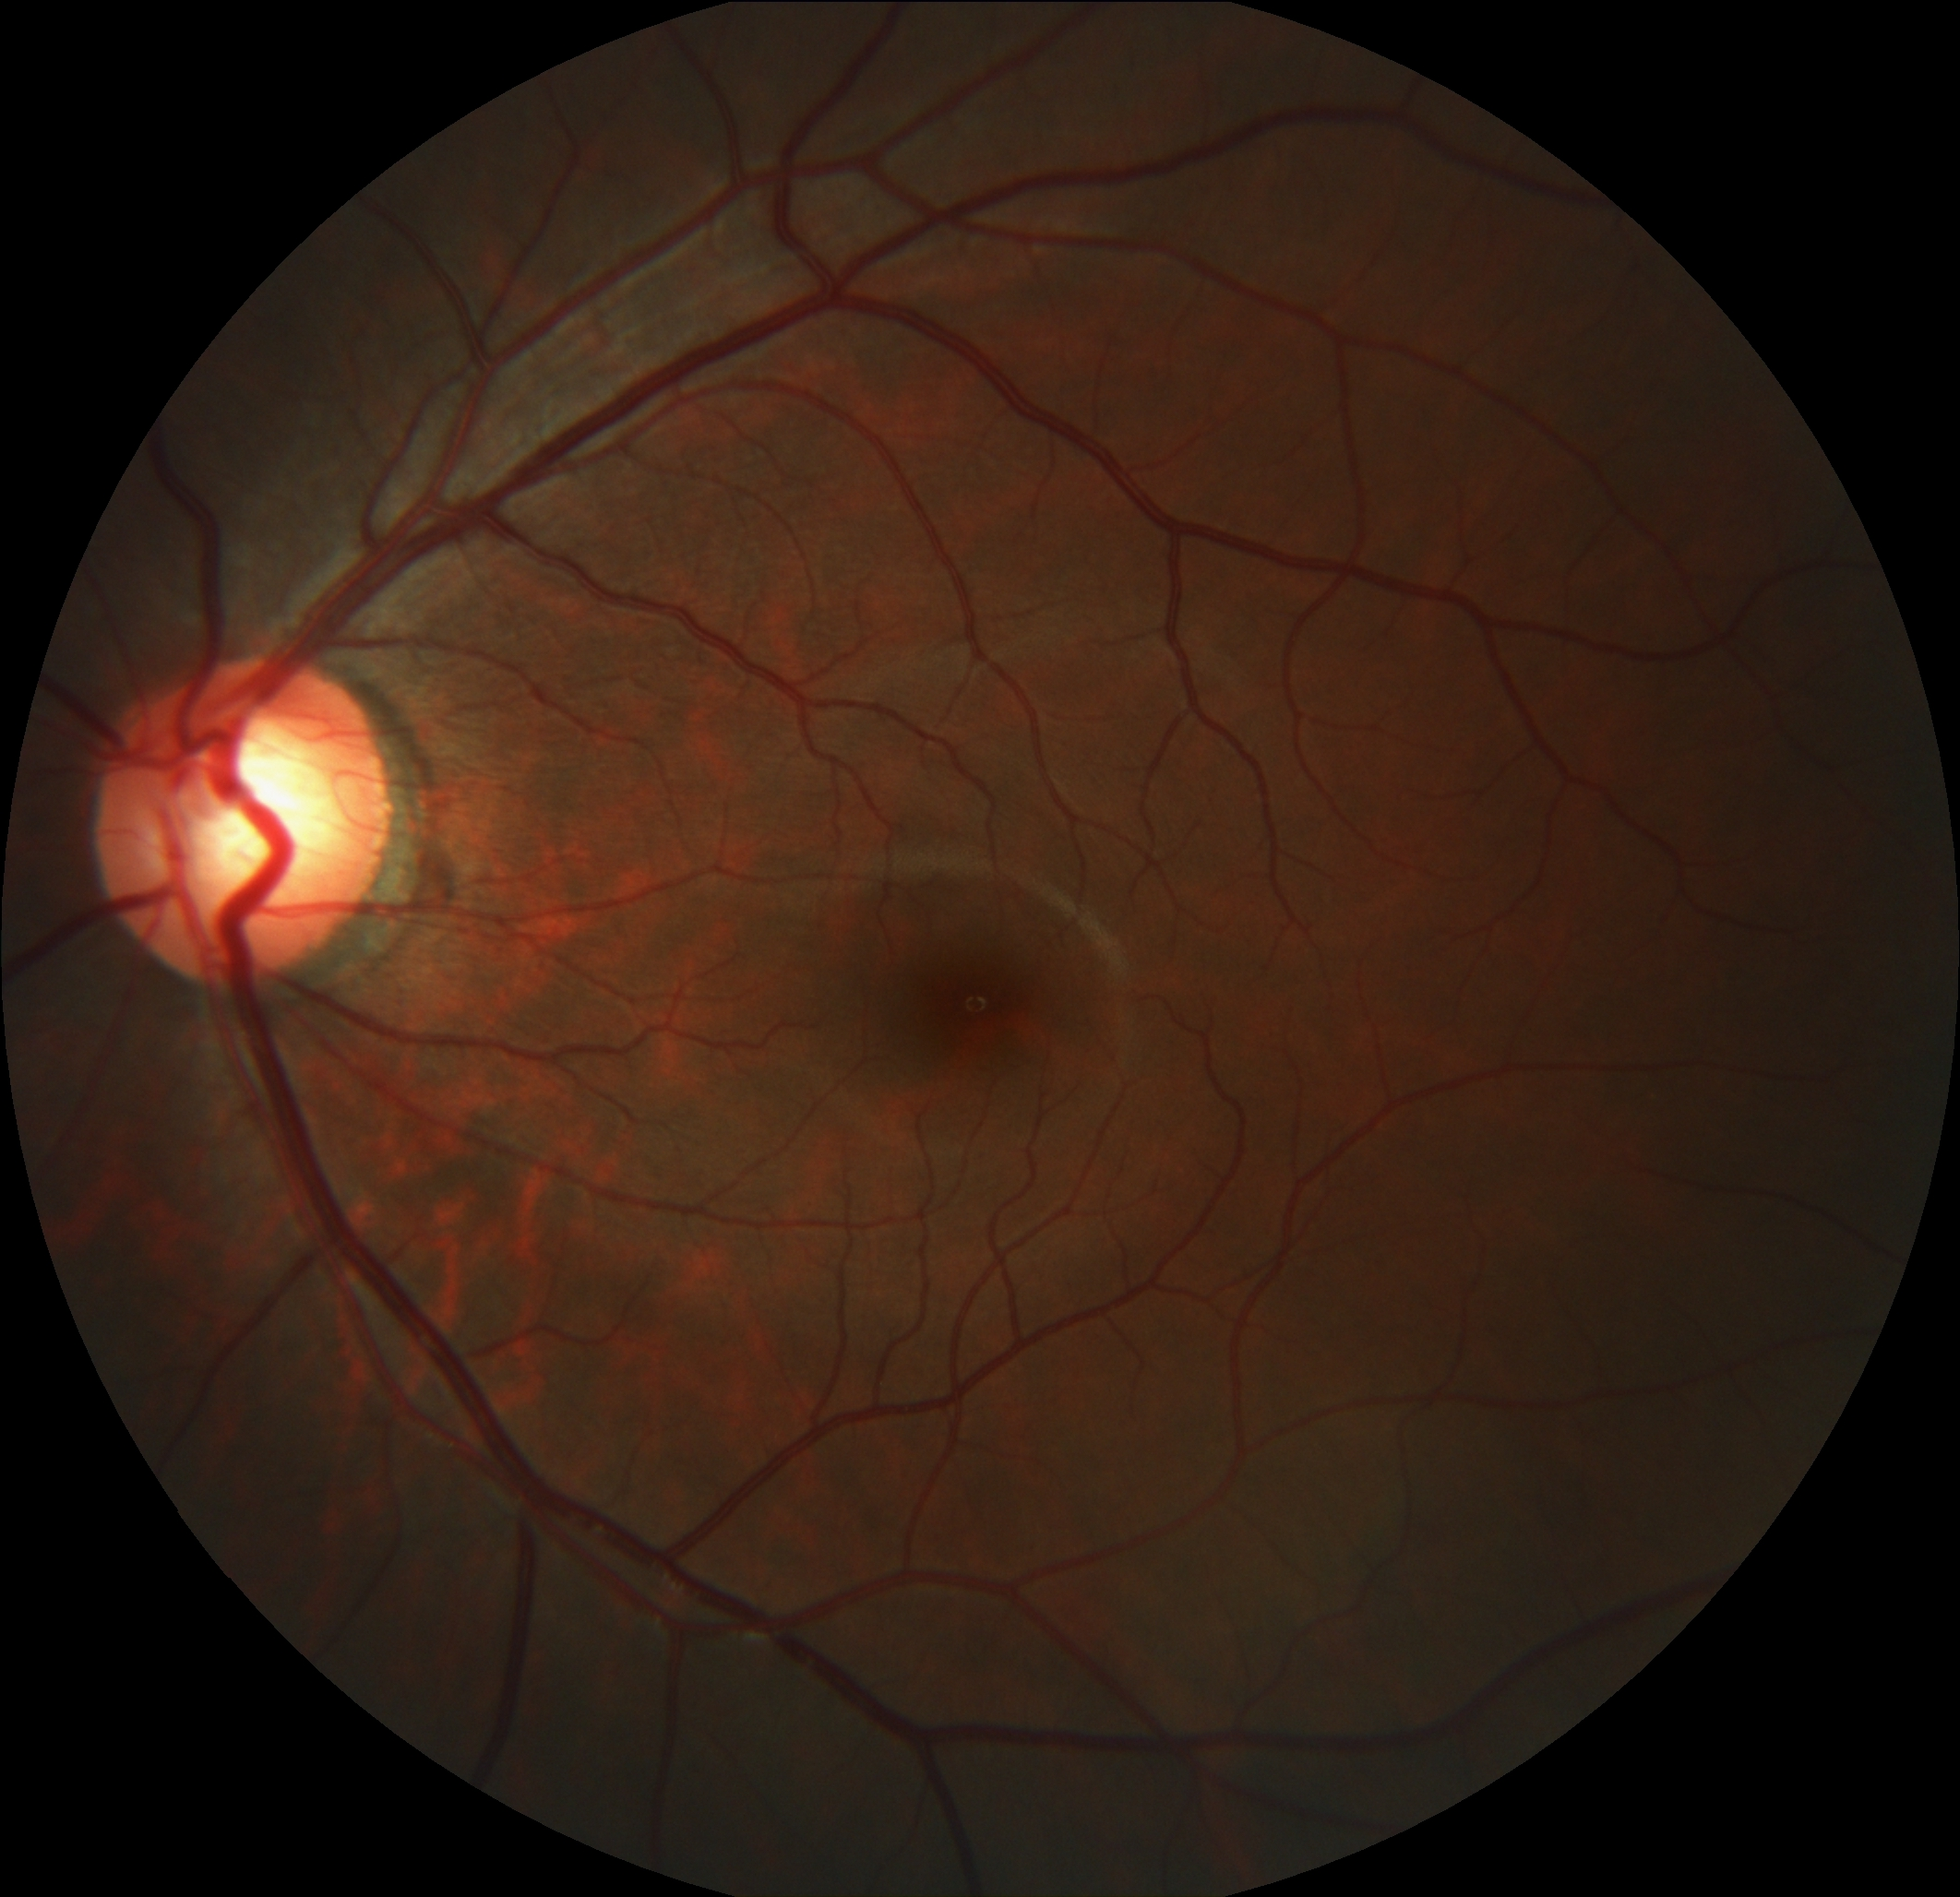

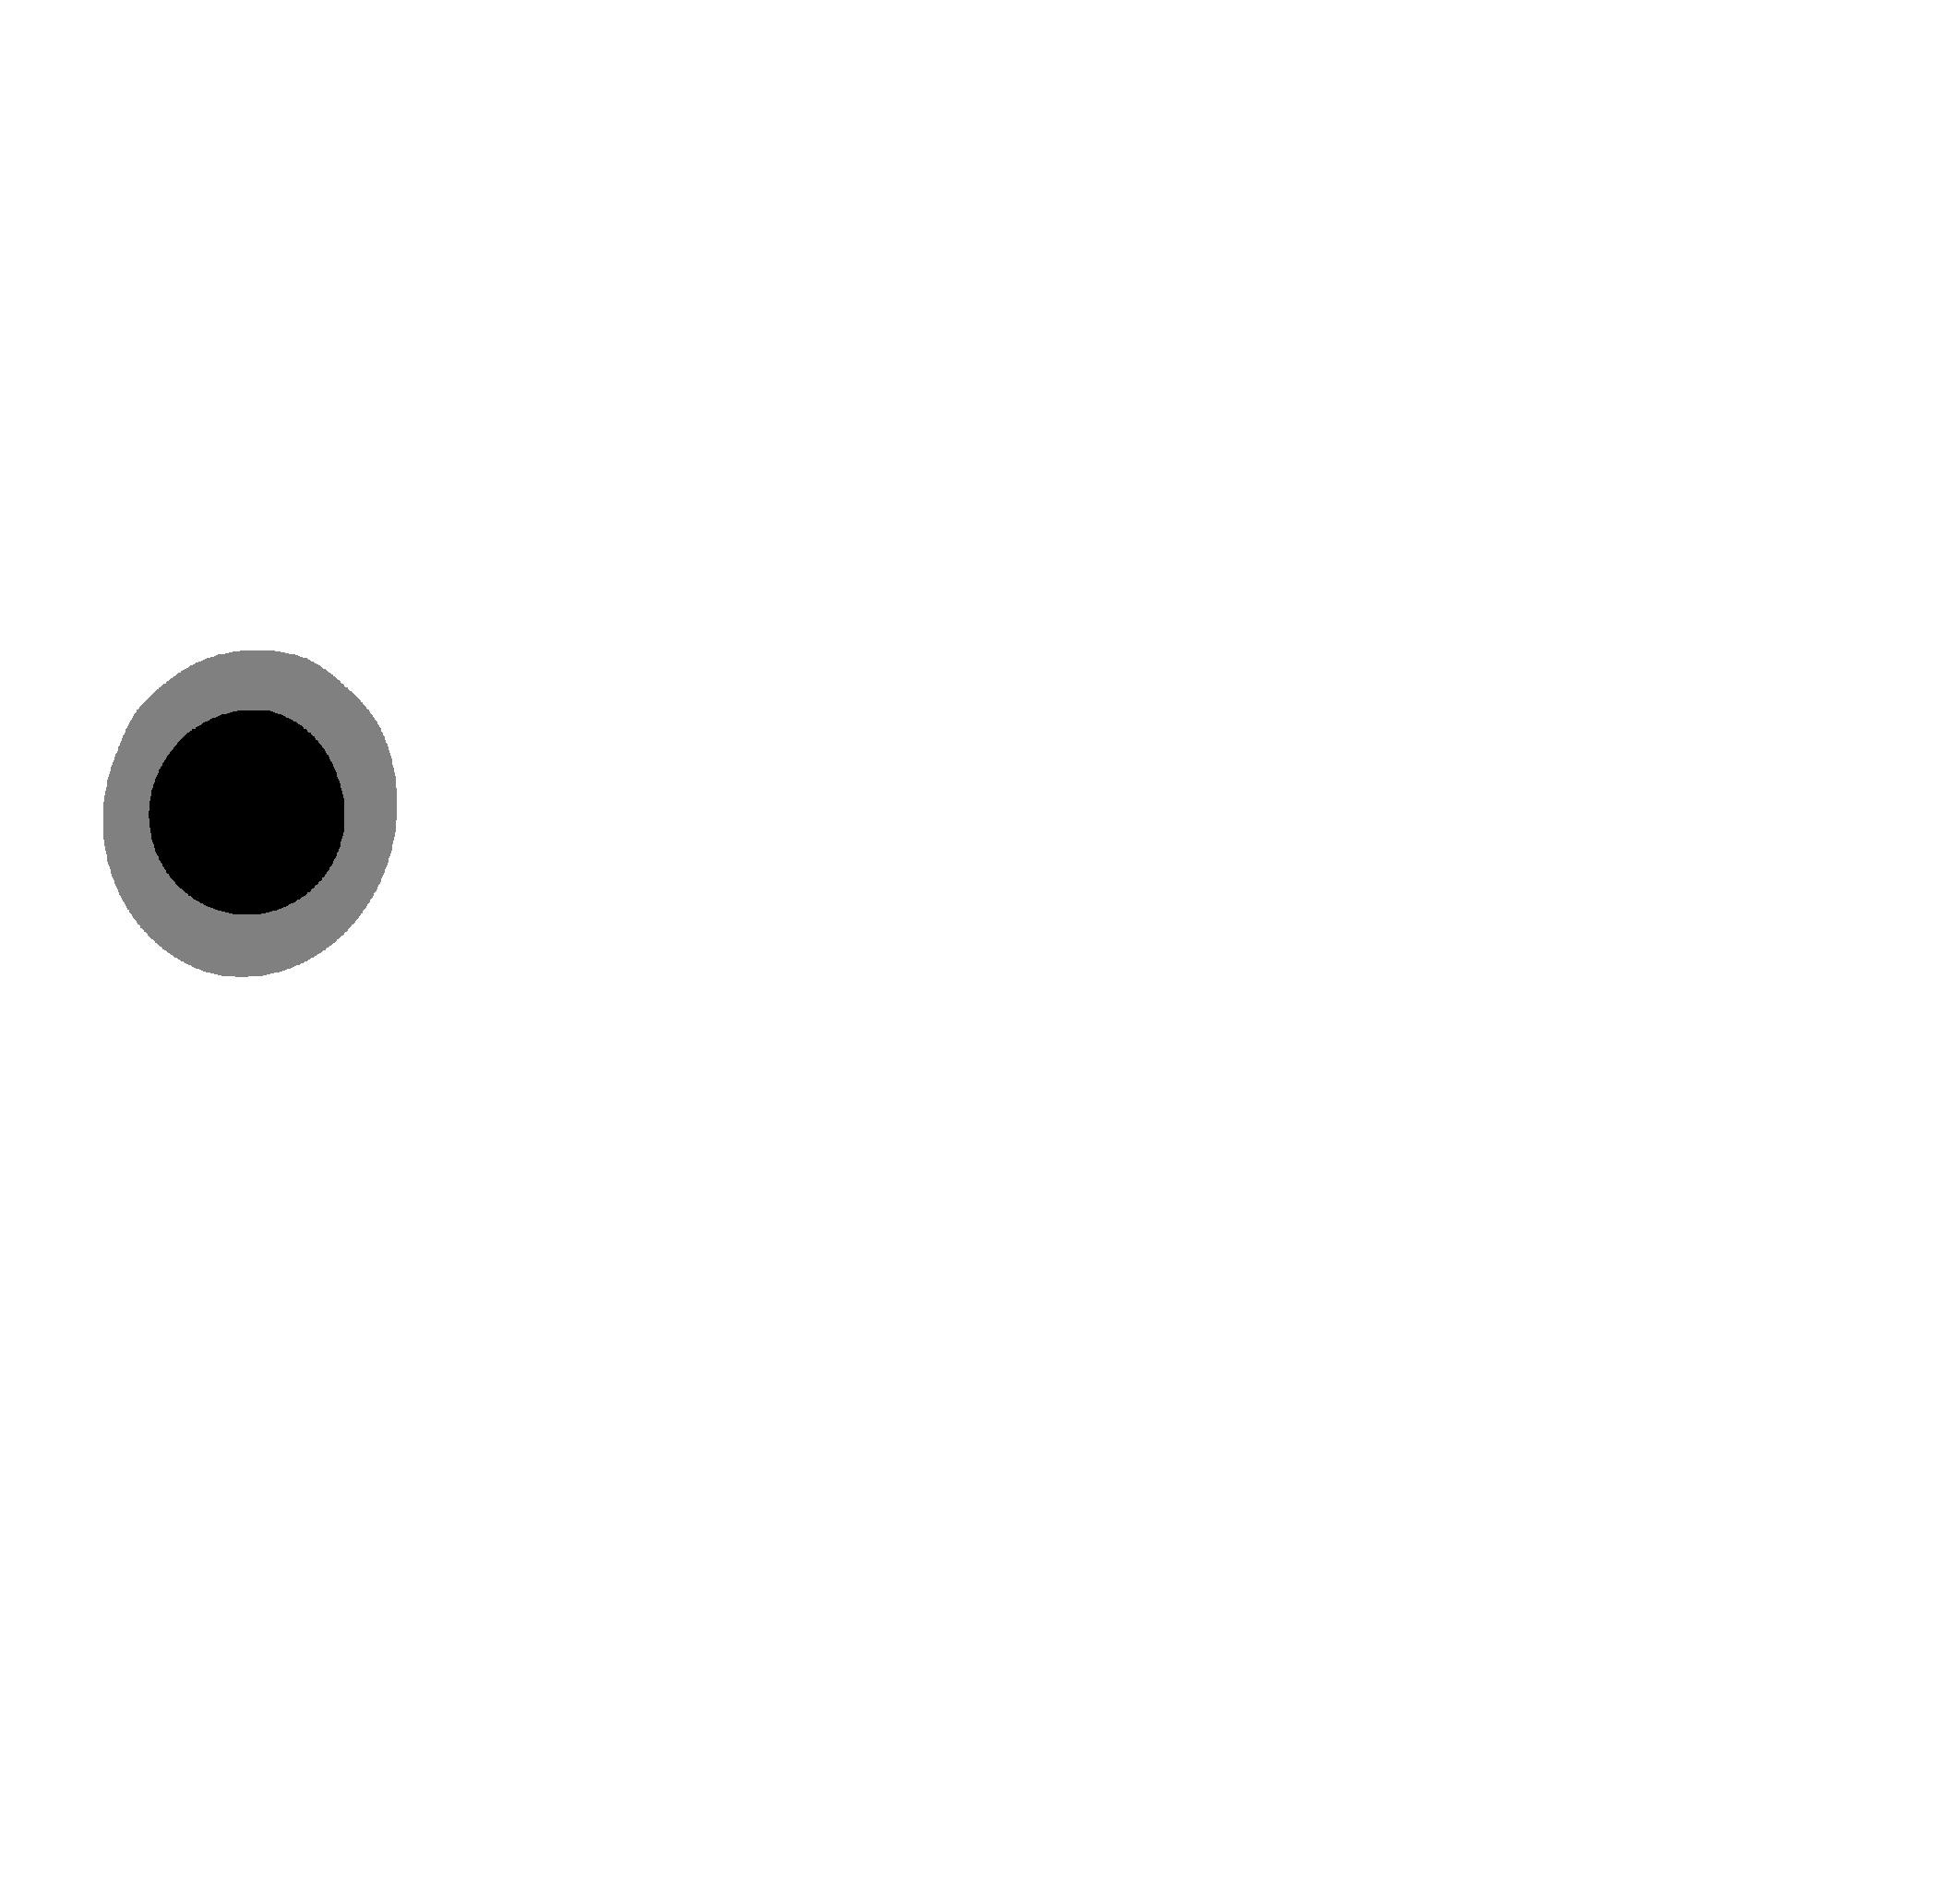

In [16]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=os.path.join(DATA_DIR, 'train','image','g0001.jpg')))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(os.path.join(DATA_DIR, 'train','mask','g0001.bmp')))
display(img)

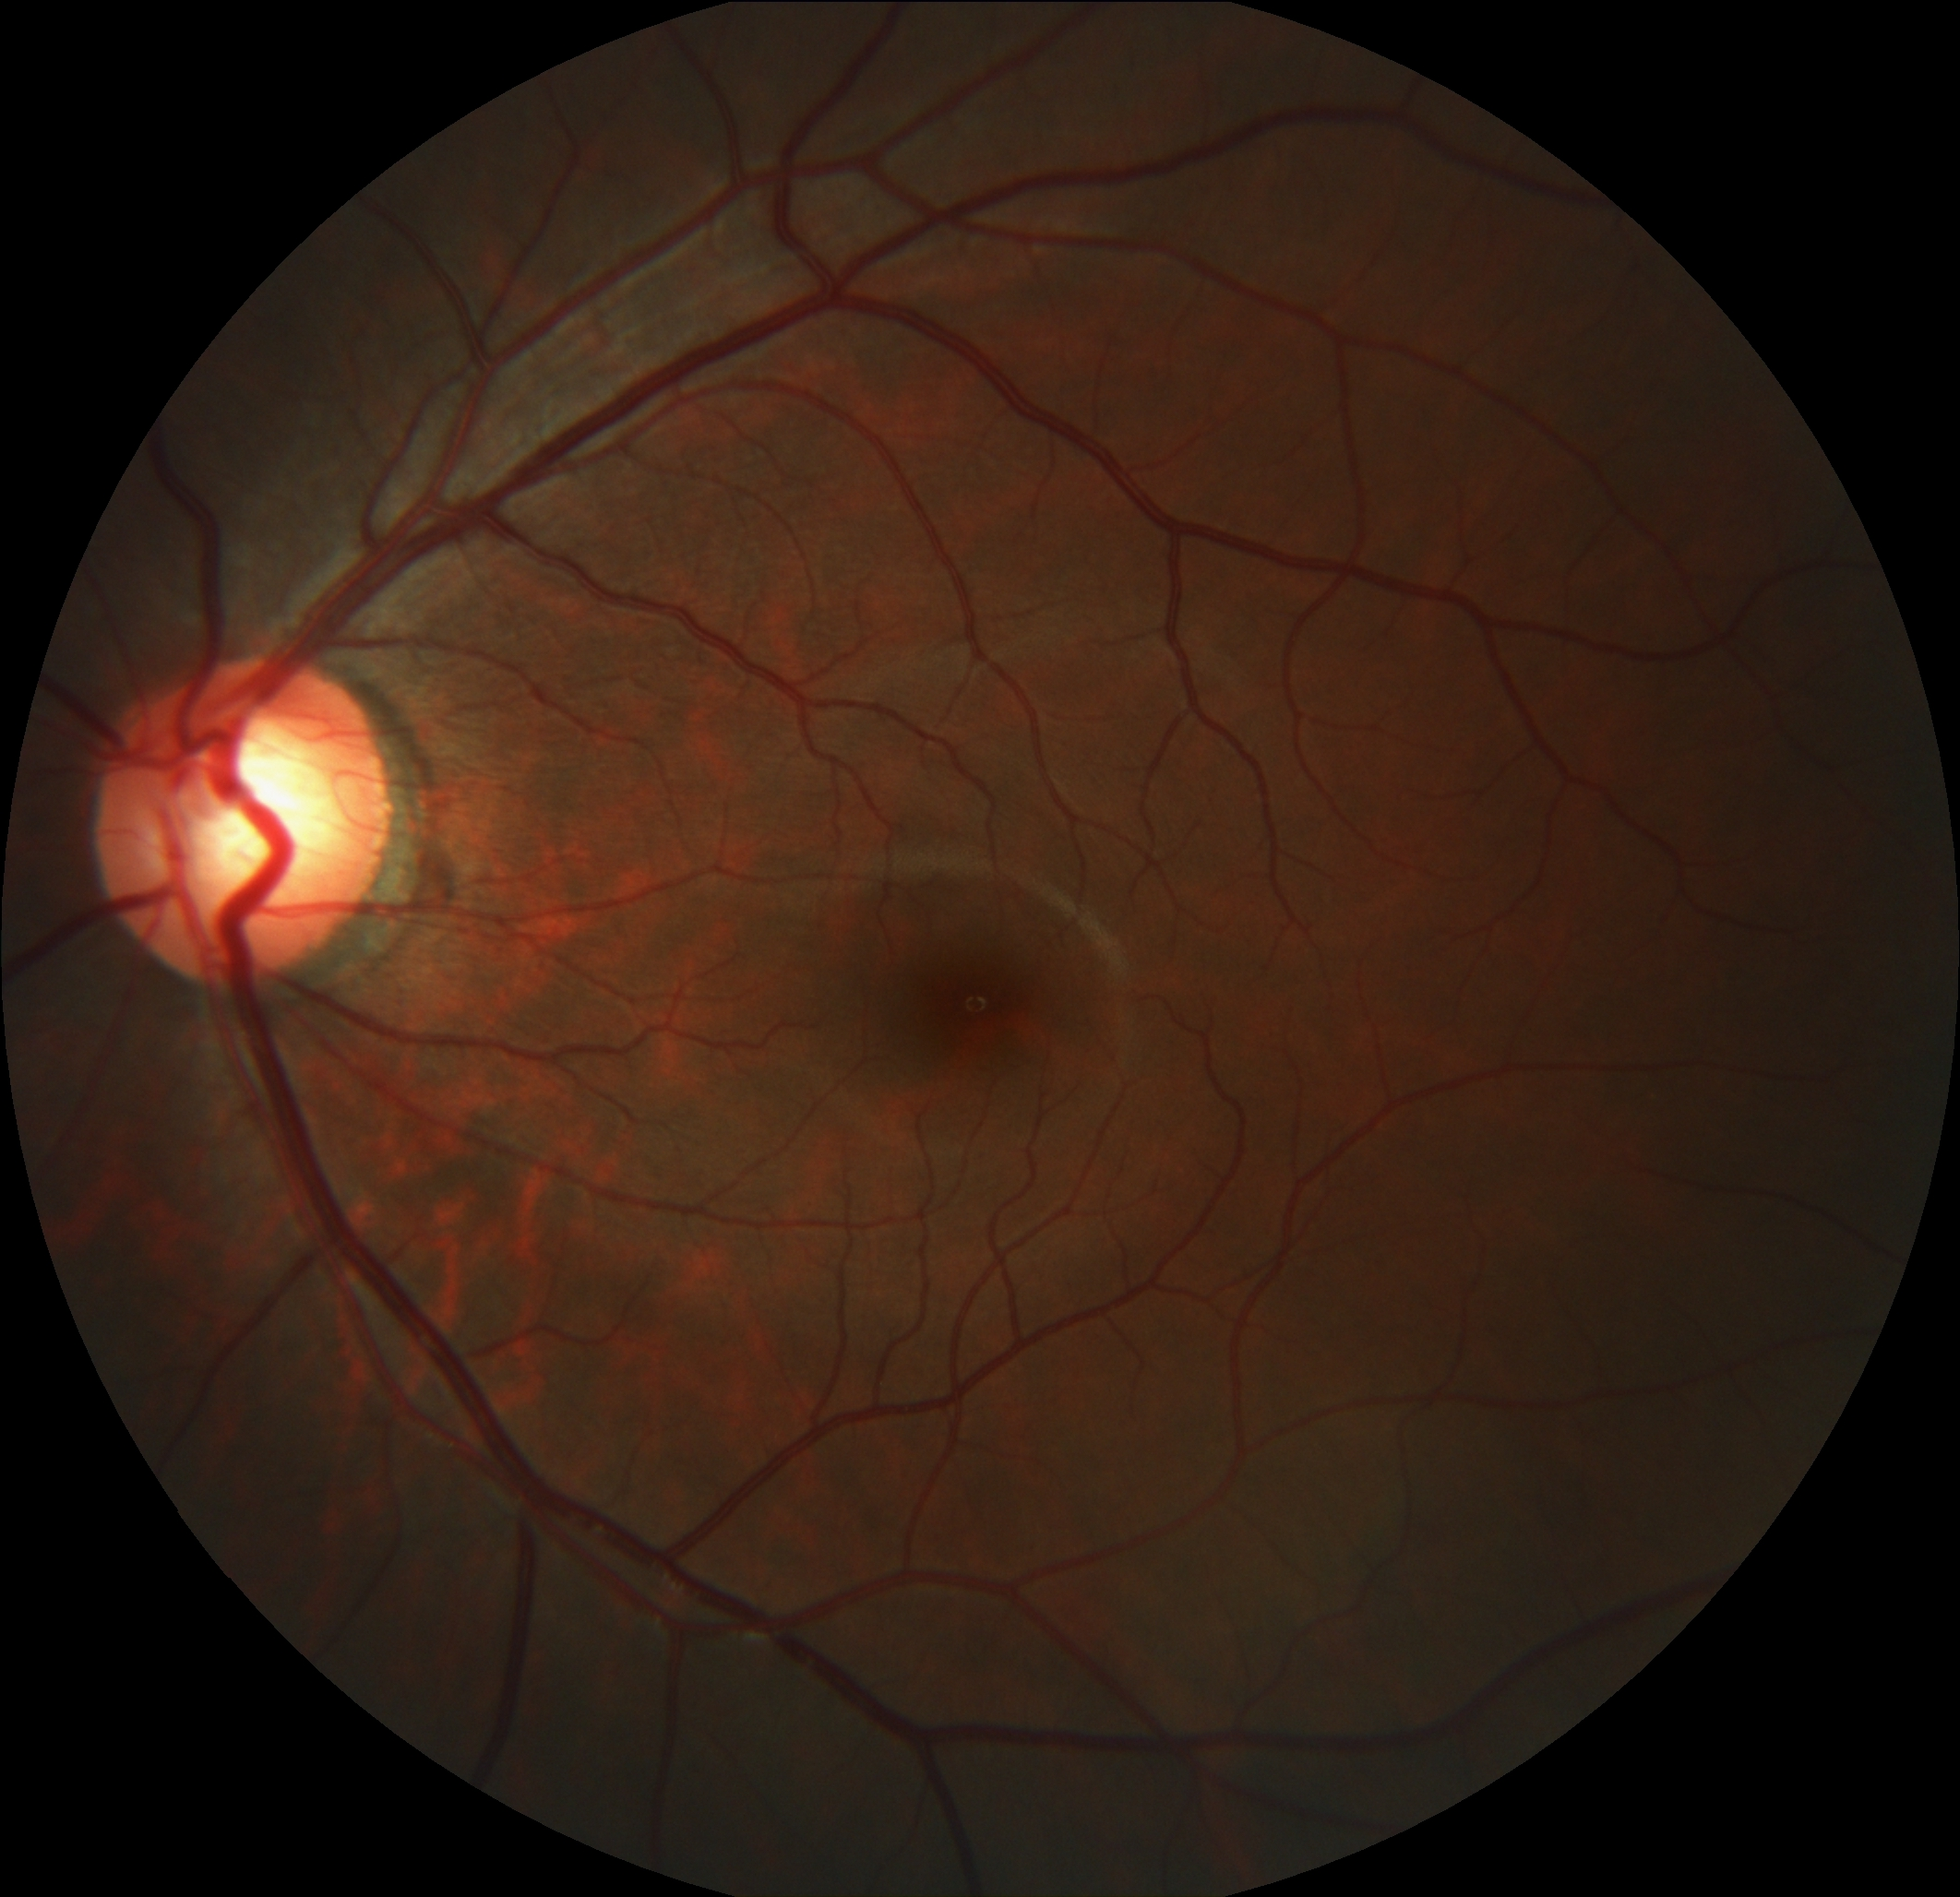

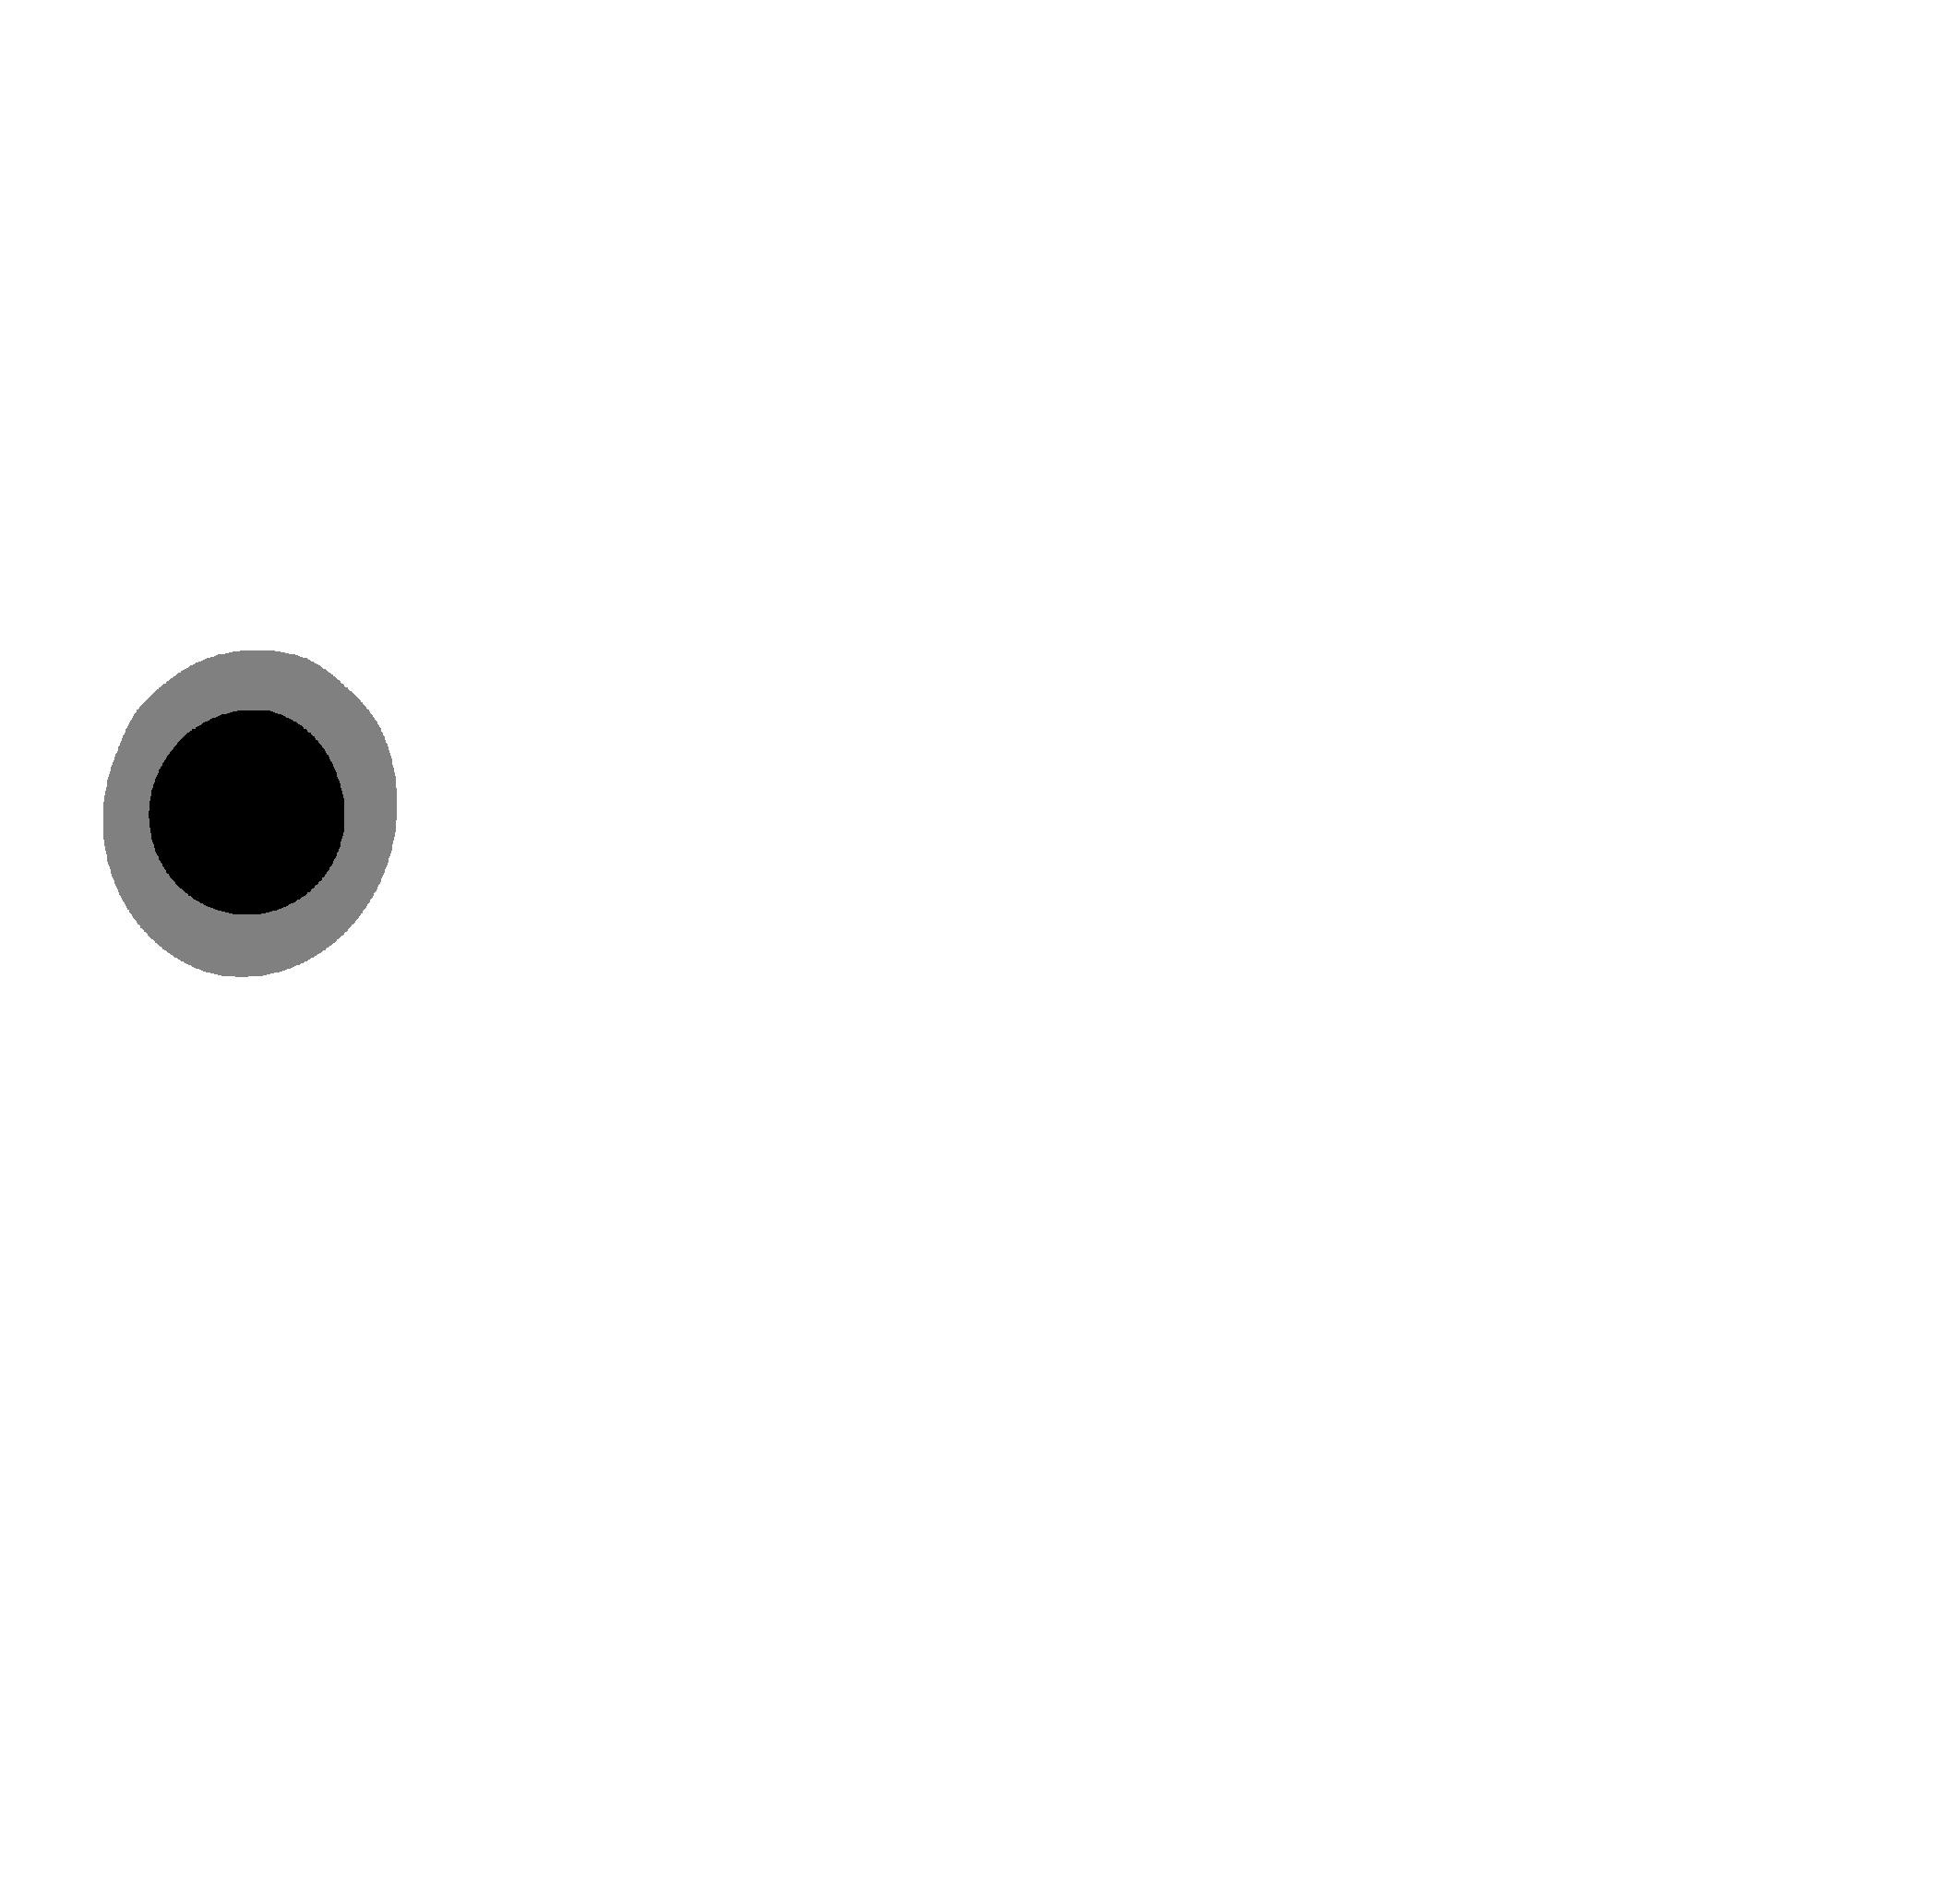

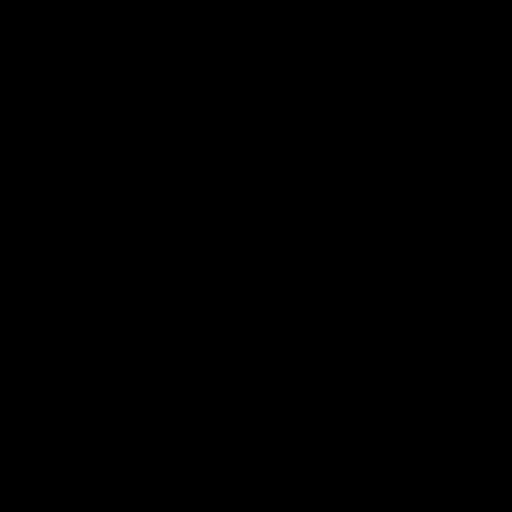

In [15]:

#results = model.predict(testGene, 10, verbose=1)


def display_mask(val_preds,i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image #7
display(Image(filename=os.path.join(DATA_DIR, 'train','image','g0001.jpg')))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(os.path.join(DATA_DIR, 'train','mask','g0001.bmp')))
display(img)

# Display mask predicted by our model
display_mask(results,0)  # Note that the model only sees inputs at 150x150.

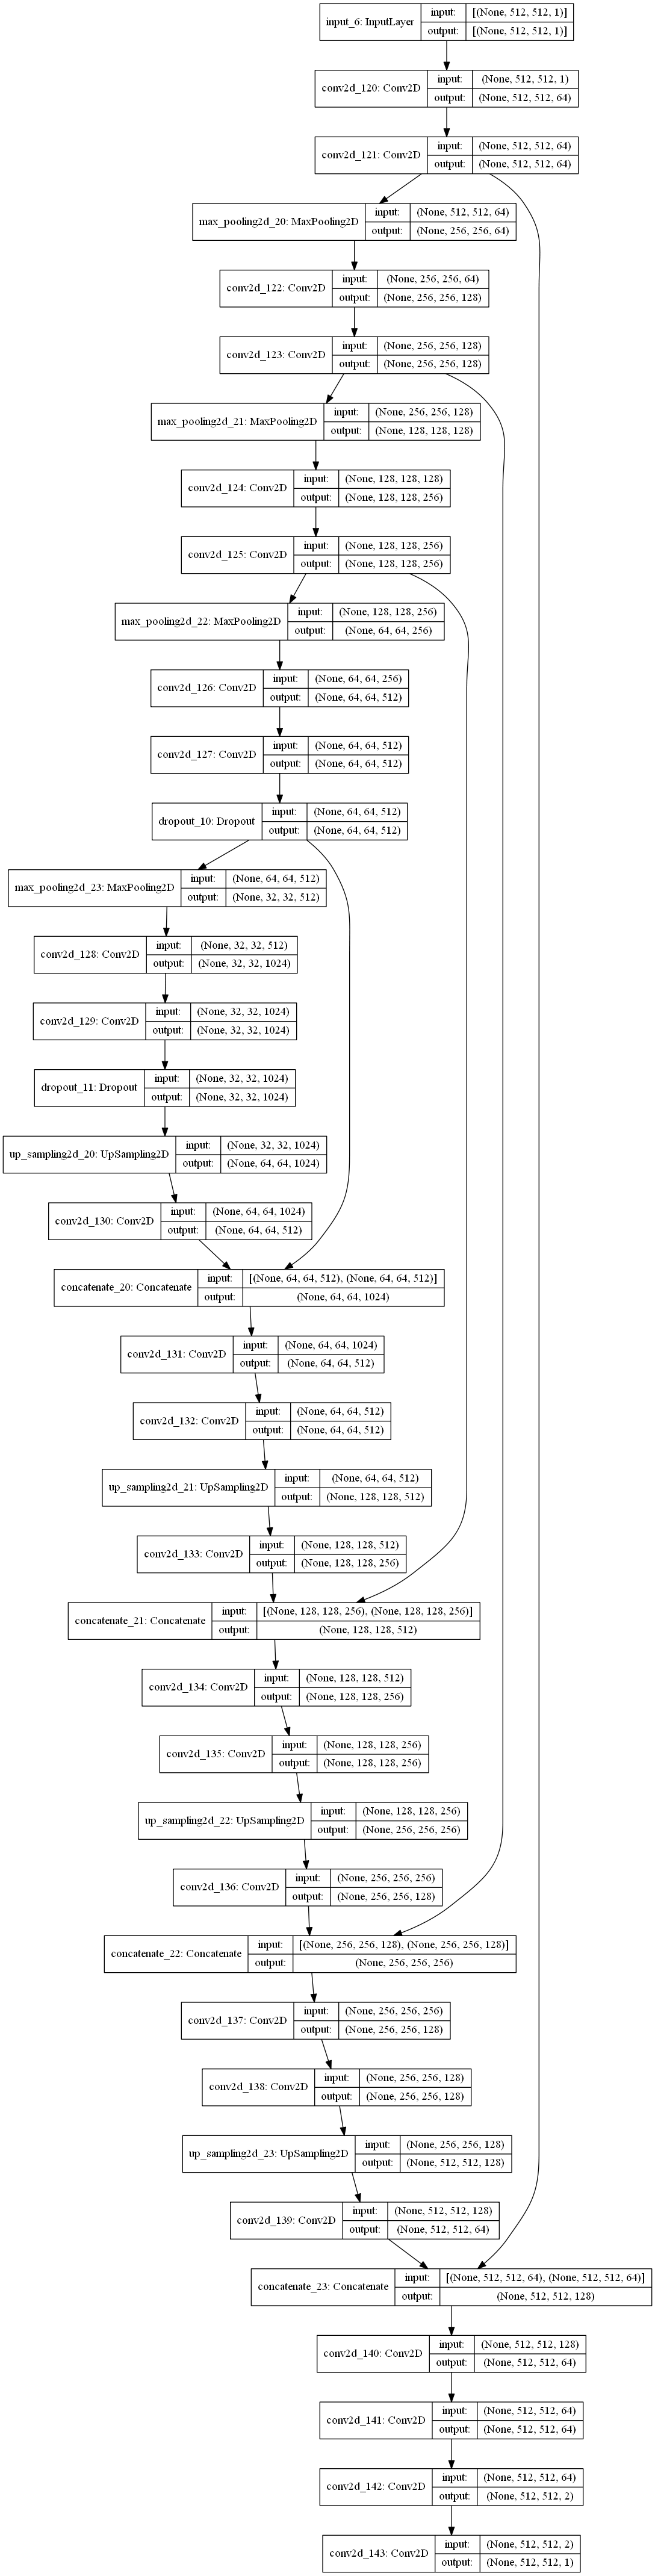

In [18]:
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(
    model,
    to_file="U_net.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)